# Data Preperation

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys

sys.path.append('..')

from src.visualizations import plot_kdes
from src.visualizations import plot_boxplots

In [2]:
# Load the processed data
df = pd.read_csv('..\data\processed\cardio_processed.csv')


## Feature Engineering

Let's intorduce new features by combining the already existing features:

Start with the BMI (Body Mass Index) calculated by BMI = weight(kg) / (height(m))^2

In [3]:
# BMI = weight(kg) / (height(m))^2
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

Introduce Pulse Pressure:

In [4]:
# Pulse Pressure (important cardiac indicator)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

Introduce Mean Arterial Pressure (MAP), calculated by map = (ap_hi) + 2 * (ap_lo) / 3

In [5]:
# Mean Arterial Pressure (MAP)
df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3

Introduce Total Number of risk Factors:

In [6]:
# Total number of risk factors
df['total_risk_factors'] = (
    df['smoke'] + 
    df['alco'] + 
    (df['cholesterol'] > 1).astype(int) + 
    (df['gluc'] > 1).astype(int) + 
    (1 - df['active'])  # Inactive is a risk factor
)

Check the distributions of the engineered variables in order to determine how do scale them:

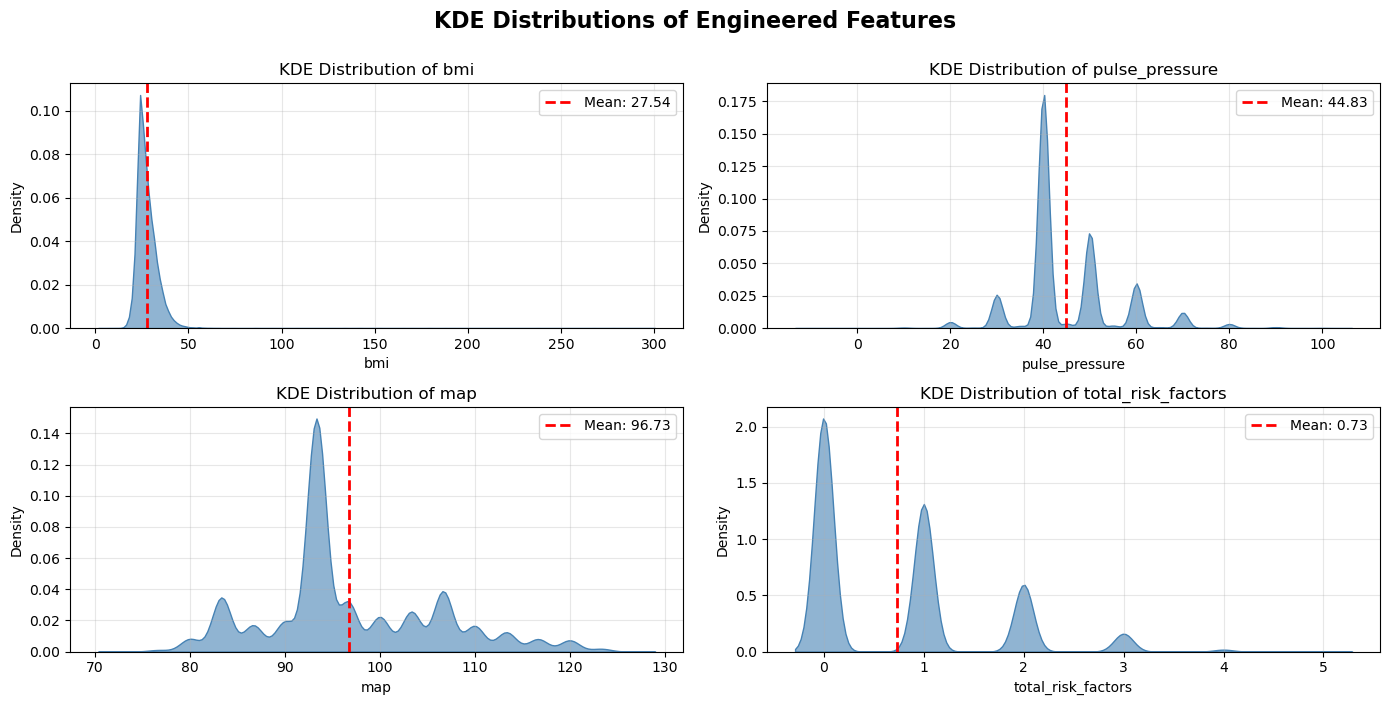

In [7]:
engineered_features = ['bmi','pulse_pressure','map','total_risk_factors']

plot_kdes(engineered_features,df,nrows=2,ncols = 2,figsize = (14,7),
          suptitle = 'KDE Distributions of Engineered Features')

BMI seems to be skewed to the right let's, check box plots for outliers:

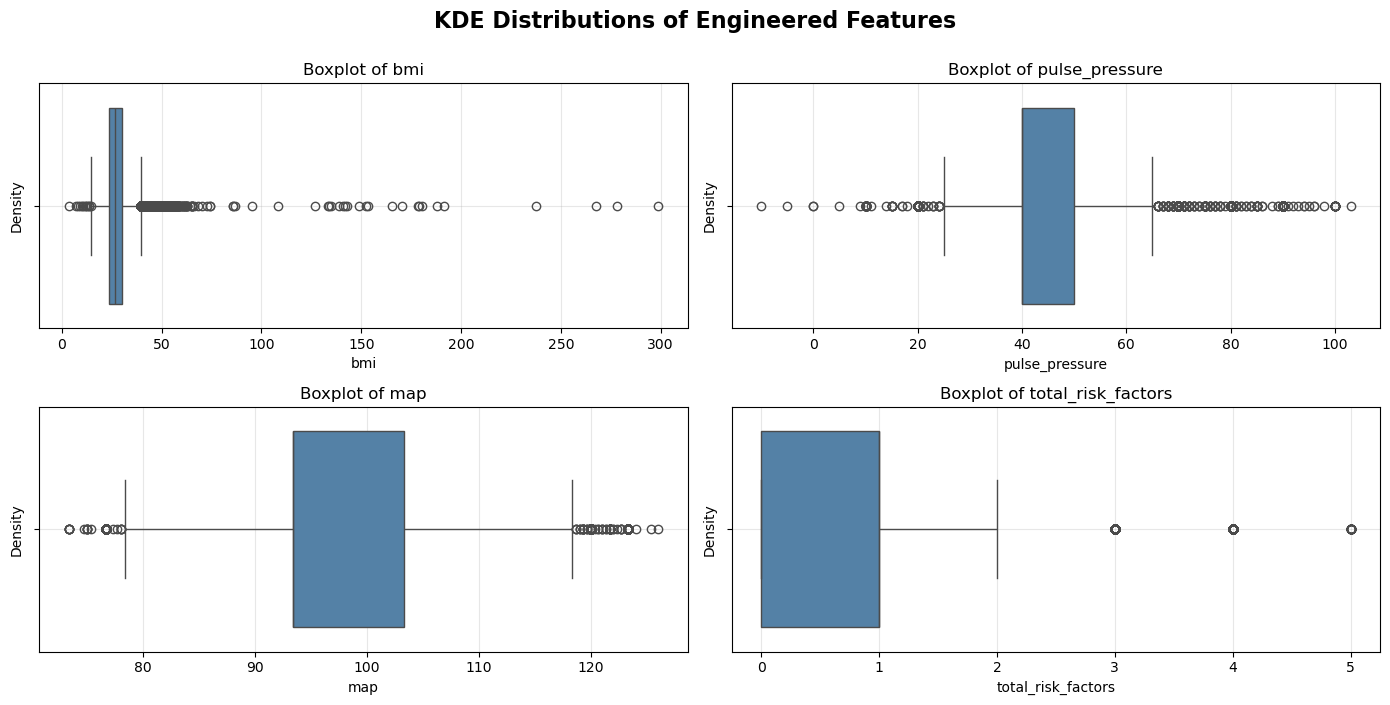

In [8]:
plot_boxplots(engineered_features,df,nrows=2,ncols = 2,figsize = (14,7),
          suptitle = 'KDE Distributions of Engineered Features')

Although BMI has extreme outliers, these ar erealisticly achievable mody mass indexes that indicate extreme obessity, therefore we can ignore it.

## Data Splitting

In [9]:
# Split the data into dependent and independent variables
X = df.drop(columns = 'cardio')
y = df['cardio']

In [10]:
# Split the data into train/test split (80/20% respectively) with stratification on the target variable
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y,shuffle = True,random_state = 42)

## Normalization/Standardization

For scaling of the features use the folowing strategy:

* height and weight - gaussian distributions, so the best strategy is standardizing.
* age, ap_hi, ap_lo, bmi, pulse_pressure, map - non-gaussian distribution, so use minmax scaler for these
* gender, cholesterol, gluc, total_risk_factors - ordinal attributes, so use minmax sclaer to get them in the 0 to 1 range
* smoke, alco, active - binary attributes, already in hte range of 0 to 1 so no need for scaling

In [11]:
minmax_scaler = MinMaxScaler()
standart_scaler = StandardScaler()

cols_to_minmax_scale = ['age','gender','ap_hi','ap_lo','cholesterol','gluc','bmi','pulse_pressure','map','total_risk_factors']
cols_to_standardize = ['height','weight']

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Fit the scalers on just the training data to avoid data leakage
minmax_scaler.fit(X_train[cols_to_minmax_scale])
standard_scaler.fit(X_train[cols_to_standardize])

# Tranform on training and test data
X_train[cols_to_minmax_scale] = minmax_scaler.transform(X_train[cols_to_minmax_scale])
X_test[cols_to_minmax_scale] = minmax_scaler.transform(X_test[cols_to_minmax_scale])

X_train[cols_to_standardize] = standard_scaler.transform(X_train[cols_to_standardize])
X_test[cols_to_standardize] = standard_scaler.transform(X_test[cols_to_standardize])

# Model Training